In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Path to the ZIP file
zip_path = "/content/drive/MyDrive/archive.zip"  # Update with your actual file path
extract_path = "/content/dataset"  # Target directory for extraction

# Unzip the file
os.system(f"unzip -q {zip_path} -d {extract_path}")
print(f"✅ Dataset extracted to: {extract_path}")

✅ Dataset extracted to: /content/dataset


Found 1479 images belonging to 30 classes.
Found 356 images belonging to 30 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training ResNet-50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 713ms/step - accuracy: 0.0661 - loss: 3.4140 - val_accuracy: 0.0955 - val_loss: 3.1701
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.1649 - loss: 3.1215 - val_accuracy: 0.1236 - val_loss: 3.0075
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - accuracy: 0.1960 - loss: 2.9192 - val_accuracy: 0.2275 - val_loss: 2.8512
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/step - accuracy: 0.2529 - loss: 2.7429 - val_accuracy: 0.2219 - val_loss: 2.6995
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.3022 - loss: 2.5283 - val_accuracy: 0.2978 - val_loss: 2.5665
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.3712 - loss: 2.3477 - val_accuracy: 0.3174 - val_loss: 2.4423
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 412ms/step - accuracy: 0.3913 - loss: 2.2277 - val_accuracy: 0.2978 - val_loss: 2.3393
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 409ms/step - accuracy: 0.4123 - loss: 2.0789 - val_accu

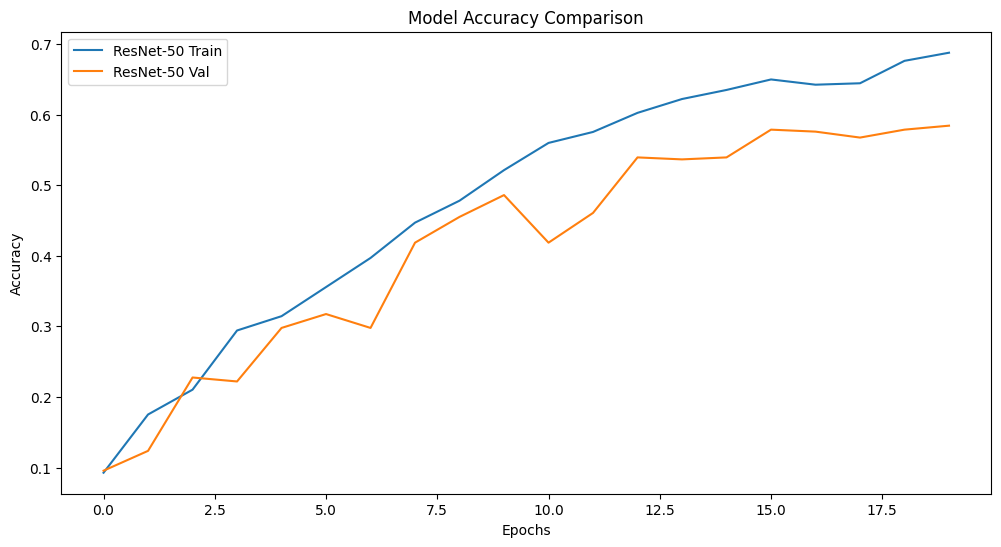

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 0.5734 - loss: 1.5733
ResNet-50 - Accuracy: 58.43% | Loss: 1.5939


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Define dataset path
dataset_path = "/content/dataset/Segmented Medicinal Leaf Images"

# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation & Loading
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

# Number of classes
num_classes = len(train_generator.class_indices)

# Function to create models
def create_model(base_model):
    base_model.trainable = False  # Freeze the convolutional base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define models
models = {
    "ResNet-50": create_model(ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))),

}

# Training all models
history_dict = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(train_generator, validation_data=val_generator, epochs=20)
    model.save(f"{name}_model.h5")
    history_dict[name] = history

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
for name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate models
for name, model in models.items():
    loss, accuracy = model.evaluate(val_generator)
    print(f"{name} - Accuracy: {accuracy * 100:.2f}% | Loss: {loss:.4f}")


In [7]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_leaf():
    # Upload an image
    uploaded = files.upload()

    for filename in uploaded.keys():
        image_path = filename

        # Load and preprocess the image
        img = load_img(image_path, target_size=IMAGE_SIZE)  # Resize to match model input
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions

        # Make prediction
        prediction = model.predict(img_array)[0][0]  # Get prediction score

        # Print result
        if prediction > 0.5:
            print("✅ Prediction: Medicinal Leaf 🌿")
        else:
            print("❌ Prediction: Not a Medicinal Leaf 🍃")

# Run prediction function
predict_leaf()


Saving banana.jpg to banana.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
❌ Prediction: Not a Medicinal Leaf 🍃
